In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib import gridspec

from copy import copy
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']

### Load Processed Data

In [2]:
#Data Unfolded From Django
cuts       = np.load('cuts.npy')
jet_pT     = np.load('jet_pT.npy')
q_perp     = np.load('q_perp.npy')
asymm_phi  = np.load('asymm_angle.npy')
weights    = np.load('weights.npy')
mc_weights = np.load("mc_weights.npy")
nn_weights = np.load("nn_weights.npy")

In [3]:
#Data Unfolded From Rapgap
cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
jet_pT_h1rpgp     = np.load('from_rapgap_jet_pT.npy')[cuts_h1rpgp]
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')[cuts_h1rpgp]
asymm_phi_h1rpgp  = np.load('from_rapgap_asymm_angle.npy')[cuts_h1rpgp]
weights_h1rpgp    = np.load('from_rapgap_weights.npy')[cuts_h1rpgp]
mc_weights_h1rpgp = np.load("from_rapgap_mc_weights.npy")[cuts_h1rpgp]
nn_weights_h1rpgp = np.load("from_rapgap_nn_weights.npy")[cuts_h1rpgp]

In [4]:
print(len(cuts_h1rpgp))
print(len(jet_pT_h1rpgp))
print(q_perp_h1rpgp)
print(q_perp)

84183898
8068863
[2.9258978 2.8795211 1.8521012 ... 0.9344905 2.9365401 1.597804 ]
[ 0.79072815 17.3027      1.250106   ...  3.4529774  17.964645
 33.857254  ]


### Load RapGap

In [5]:
rapgap_cuts      = np.load('rapgap_cuts.npy')
rapgap_jet_pT    = np.load('rapgap_jet_pT.npy')[rapgap_cuts]
rapgap_q_perp    = np.load('rapgap_q_perp.npy')[rapgap_cuts]
rapgap_asymm_phi = np.load('rapgap_asymm_angle.npy')[rapgap_cuts]
rapgap_weights   = np.load('rapgap_weights.npy')[rapgap_cuts]

In [6]:
raw_cuts = np.load("dataRaw_cuts.npy")
raw_q_perp = np.load("dataRaw_q_perp.npy")

cut_on_raw=True
if cut_on_raw:
    raw_q_perp=raw_q_perp[raw_cuts]

### Apply Cuts

In [7]:
if (len(q_perp) == len(cuts)):
    jet_pT    = jet_pT[cuts]
    q_perp    = q_perp[cuts]
    asymm_phi = asymm_phi[cuts]
    weights   = weights[cuts]
    mc_weights = mc_weights[cuts]
    nn_weights = nn_weights[cuts]
    print("%i / %i Events Remain"%(len(q_perp),len(cuts)))

else:
    print("Cuts already applied!")
    

7244351 / 93608656 Events Remain


___

## Calculate Bin Average $\cos(\phi), \cos(2\phi)$, and $\cos(3\phi)$ in Bins of $q_\perp$

### Dictionaryies and Binning

In [8]:
#Make Dictionaries and Binning
N_Bins = 10
q_max = 10.51

#q_perp_bins = np.arange(0,10.51,1.5)
#N_Bins = int(10.51/1.5)
q_perp_bins = np.linspace(0,q_max,N_Bins+1)

digits = np.digitize(q_perp,q_perp_bins)-1
keys=["q_perp","cos1","cos2","cos3"]

h1_of = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

django = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

rapgap = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

h1_rpgp = dict(zip(
["q_perp","cos1","cos2","cos3"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

In [9]:
print(N_Bins)

10


In [10]:
print(q_perp_bins)

[ 0.     1.051  2.102  3.153  4.204  5.255  6.306  7.357  8.408  9.459
 10.51 ]


## Ensemble of BootStrapped Errors

In [11]:
boot_ensemble = np.load("bootstrap_rapgap_weights.npy")

In [12]:
def get_bootstrap_errors(boot_ensemble,Binning,Observable,cuts):

    N_Bootstraps = np.shape(boot_ensemble)[0]
    #N_Bootsraps = 10
    N_Bins = len(Binning)-1
    bin_wsums = np.zeros((N_Bootstraps,N_Bins))
    for istrap in range(N_Bootstraps):
        counts,_,_ = plt.hist(Observable,weights=boot_ensemble[istrap][cuts],bins=Binning,density=True,histtype="step") #weighted sums in each bin
        #print(counts[0])
        #fig , ax = plt.subplots(1,1,figsize=(8,8))
        #ax = ax.flatten()
        #ax.hist(boot_ensemble[istrap][cuts],density=True)
        bin_wsums[istrap]=counts  #row = bootstrap iteration, column = bin number

    btstrp_errors = np.zeros(N_Bins)
    bin_wsums = bin_wsums.T #row = bin number, column = boostrap iter
    for ibin in range(N_Bins):
        btstrp_errors[ibin] = np.nanstd(bin_wsums[ibin])/np.nanmean(bin_wsums[ibin]) #These means they are RELATIVE Errors!
        #print("bin",ibin,":",np.nanstd(bin_wsums[ibin]),"/",np.nanmean(bin_wsums[ibin]),"=",btstrp_errors[ibin])

    return(btstrp_errors)

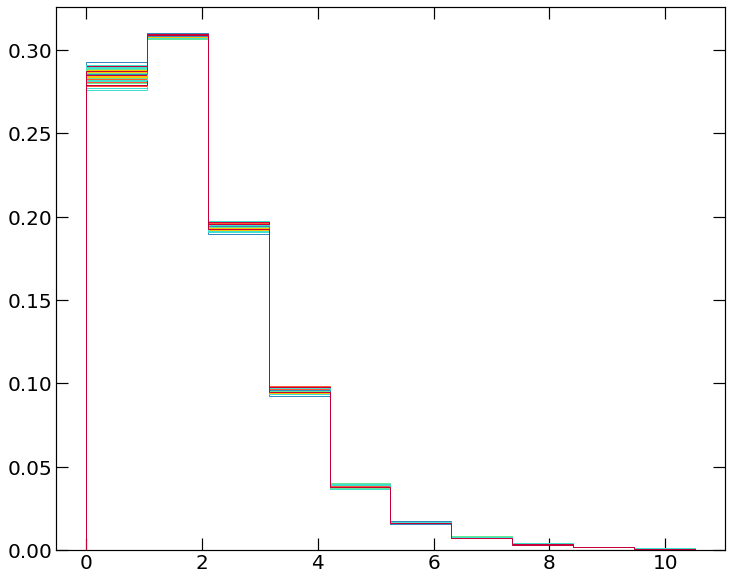

In [13]:
#%%capture
btstrp_errors = get_bootstrap_errors(boot_ensemble,q_perp_bins,q_perp_h1rpgp,cuts_h1rpgp)
np.save("rapgap_btstrp_errors.npy",btstrp_errors)
#btstrp_errors = np.load("rapgap_btstrp_errors.npy")

In [14]:
def averages_in_qperp_bins(dic, N_Bins,q_perp,asymm_phi,weights,q_max=10.51):
    
    q_perp_bins = np.linspace(0,q_max,N_Bins+1)
    digits = np.digitize(q_perp,q_perp_bins)-1
    
    q_w = q_perp*weights
    cos1_w = np.cos(1*asymm_phi)*weights
    cos2_w = np.cos(2*asymm_phi)*weights
    cos3_w = np.cos(3*asymm_phi)*weights
    
    for i in range(N_Bins):
        bin_mask = digits==i
        bin_wsum = np.sum(weights[bin_mask])
        
        dic["q_perp"][i]  = np.nansum(q_w[bin_mask])/bin_wsum
        dic["phi"][i] = np.nansum(asymm_phi[bin_mask])/bin_wsum
        dic["cos1"][i] = np.nansum(cos1_w[bin_mask])/bin_wsum
        dic["cos2"][i] = np.nansum(cos2_w[bin_mask])/bin_wsum
        dic["cos3"][i] = np.nansum(cos3_w[bin_mask])/bin_wsum
        dic["errors"][i] = 1/np.sqrt(np.nansum(bin_wsum))
    return

In [15]:
django = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

averages_in_qperp_bins(django, N_Bins, q_perp, asymm_phi,mc_weights)

In [16]:
rapgap = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

averages_in_qperp_bins(rapgap, N_Bins, rapgap_q_perp, rapgap_asymm_phi,rapgap_weights)

In [17]:
#Data unfolded USING Django
h1_djgo = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

averages_in_qperp_bins(h1_djgo, N_Bins, q_perp, asymm_phi,weights)
#plt.hist(h1_of["cos1"],alpha=0.5)

## Dictionary of Unfolded H1 Data (Main results use RAPGAP)

In [18]:
#Data unfolded USING Rapgap
h1_rpgp = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

averages_in_qperp_bins(h1_rpgp, N_Bins, q_perp_h1rpgp, asymm_phi_h1rpgp,weights_h1rpgp)
h1_rpgp["errors"] = btstrp_errors

## Uncertainties

In [19]:
model_sys = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

total_error = dict(zip(
["q_perp","phi","cos1","cos2","cos3","errors"],
[np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins),
 np.zeros(N_Bins),np.zeros(N_Bins)]))

for i,key in enumerate(keys[1:]):
    model_sys[key] = np.abs(h1_rpgp[key]-h1_djgo[key]/h1_rpgp[key]) #RELATIVE uncertainty
    total_error[key] = np.sqrt((model_sys[key])**2+btstrp_errors**2)
#FIXME: ADD IN OTHER SYSTEMATICS!!

In [20]:
x_low =  h1_rpgp["q_perp"] - q_perp_bins[:-1]
x_high = q_perp_bins[1:] - h1_rpgp["q_perp"]
x_errors = np.array(list(zip(x_low,x_high))).T
edges=np.stack((q_perp_bins[:-1],q_perp_bins[1:])).T

In [21]:
print(edges)

[[ 0.     1.051]
 [ 1.051  2.102]
 [ 2.102  3.153]
 [ 3.153  4.204]
 [ 4.204  5.255]
 [ 5.255  6.306]
 [ 6.306  7.357]
 [ 7.357  8.408]
 [ 8.408  9.459]
 [ 9.459 10.51 ]]


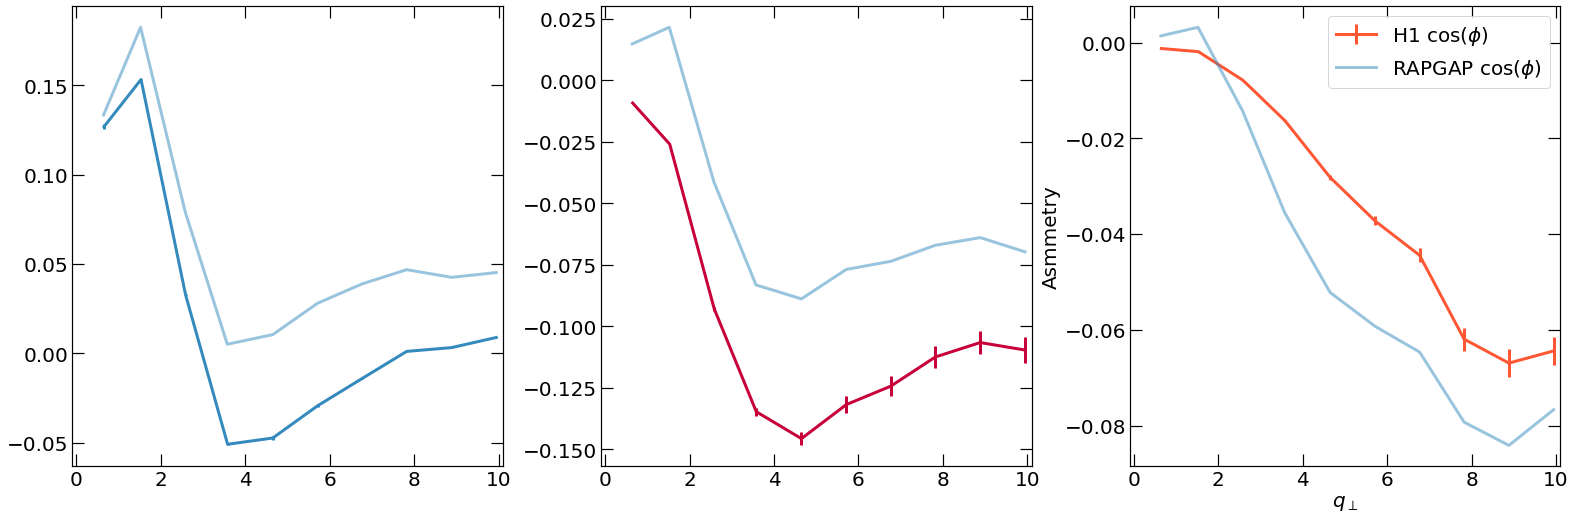

In [22]:
fig,axes = plt.subplots(1,3,figsize=(22,7))
#fig = plt.figure(figsize=(10,8))
#colors=["blue","purple","red"]
for i,key in enumerate(keys[1:]):
    axes[i].errorbar(h1_rpgp["q_perp"],h1_rpgp[key],yerr=btstrp_errors*h1_rpgp[key],label="H1 $\cos(\phi)$",color=colors[i],linewidth=3)

for i,key in enumerate(keys[1:]):
    axes[i].errorbar(rapgap["q_perp"],rapgap[key],label="RAPGAP $\cos(\phi)$",alpha=0.5,linewidth=3)
    #axes[i].set_ylim(-0.61,0.61)
    axes[i].set_xlim(-0.1,10.1)

plt.tight_layout()
plt.legend(fontsize=20)
plt.xlabel("$q_\perp$",fontsize=20)
plt.ylabel("Asmmetry",fontsize=20)
plt.savefig("unfolded_separately.pdf")

___

## Theory https://arxiv.org/pdf/2106.05307.pdf

In [23]:
theory = {}

for i in range(1,4):
    key = "cos%i"%(i)
    theory[key] = np.load("theory_cos%iphi.npy"%(i))
    key = key+"_x"
    theory[key] = np.load("theory_cos%iphi_x.npy"%(i))

## Pythia [Roli+Kyle]

In [24]:
pythia = {}

for i in range(1,4):
    key = "cos%i"%(i)
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,1]
    key = key+"_x"
    pythia[key] = genfromtxt('Pythia_cos%iphi_v_qT.csv'%(i), delimiter=',')[:,0]

___

In [25]:
print(x_errors)

[[0.65226374 0.47890342 0.48241276 0.42718507 0.44493441 0.45612893
  0.4617066  0.46419521 0.47423387 0.48088746]
 [0.39873626 0.57209658 0.56858724 0.62381493 0.60606559 0.59487107
  0.5892934  0.58680479 0.57676613 0.57011254]]


## Overlay Everything

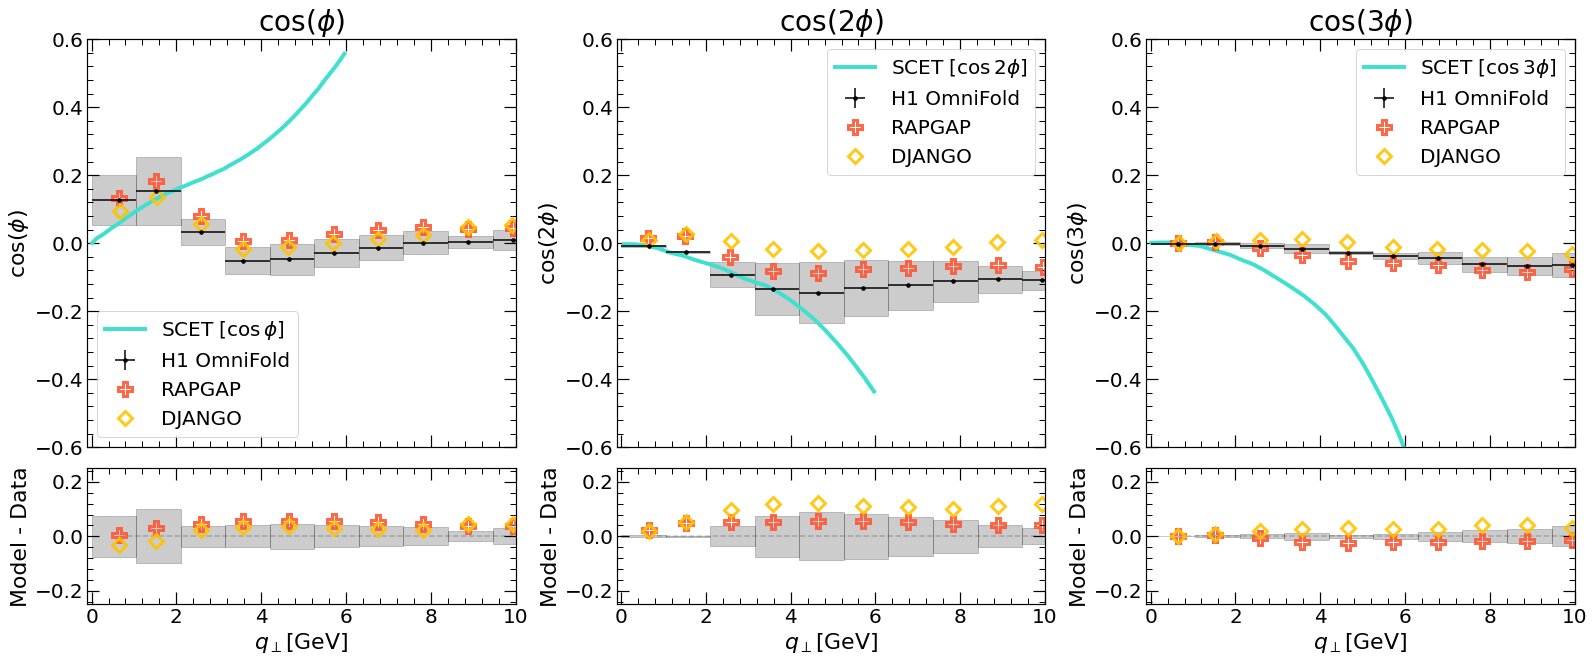

In [31]:
plot_h1rpgp = True #Default. Only one with bootstrap errors
plot_h1djgo = False

plot_rapgap = True
plot_django = True

plot_theory = True
plot_pythia = False

plot_modelSYS = True

plot_mask = np.asarray([plot_h1rpgp,plot_h1djgo,plot_rapgap,plot_django,plot_theory,plot_pythia, #data
                        plot_modelSYS])

#fig = plt.figure(figsize=(10,8))
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 9), constrained_layout=True,
                         gridspec_kw={'height_ratios': [3, 1]})
x_max = 10.0

#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7), constrained_layout=True)
axes = np.ravel(axes)

#Omnifold H1 Data        
if (plot_h1rpgp):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(h1_rpgp["q_perp"],h1_rpgp[key],yerr=btstrp_errors*h1_rpgp[key],xerr=x_errors,
                         label="H1 OmniFold",ls='none',ms=7,marker=".", color='black',zorder=20)
        
if (plot_h1djgo):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(h1_djgo["q_perp"],h1_djgo[key],xerr=q_perp_widths,
                         label="H1 OmniFold [Django]",ls='none',ms=7,marker=".",color='grey')

if (plot_modelSYS):
    for i,key in enumerate(keys[1:]):
        model_difference = np.abs(h1_rpgp[key]-h1_djgo[key])
        for xi in range(len(edges)):
            axes[i].fill_between(edges[xi],h1_rpgp[key][xi]-model_sys[key][xi]*h1_rpgp[key][xi],
                                 h1_rpgp[key][xi]+model_sys[key][xi]*h1_rpgp[key][xi], alpha=0.2,color='k',)
        
#H1 Simulation
if (plot_rapgap):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(rapgap["q_perp"],rapgap[key],label="RAPGAP",ls='none',marker="P",fillstyle='none',markeredgewidth=3,ms=14,alpha=0.9, color=colors[2])
        
if (plot_django):
    for i,key in enumerate(keys[1:]):
        axes[i].errorbar(django["q_perp"],django[key],label="DJANGO",ls='none',marker="D",fillstyle='none',markeredgewidth=3,ms=10,alpha=0.9, color=colors[3])


if (plot_theory):
    axes[0].plot(theory['cos1_x'],theory['cos1'],label="SCET [$\cos\phi$]",linewidth=4,linestyle="solid",color=colors[5])
    axes[1].plot(theory['cos2_x'],theory['cos2'],label="SCET [$\cos2\phi$]",linewidth=4,linestyle="solid",color=colors[5])
    axes[2].plot(theory['cos3_x'],theory['cos3'],label="SCET [$\cos3\phi$]",linewidth=4,linestyle="solid",color=colors[5])
    
if (plot_pythia):
    axes[0].plot(pythia['cos1_x'],pythia['cos1'],label="Pythia [$\cos\phi$]",linewidth=4,linestyle="dashed",color=colors[4])
    axes[1].plot(pythia['cos2_x'],pythia['cos2'],label="Pythia [$\cos2\phi$]",linewidth=4,linestyle="dashed",color=colors[4])
    axes[2].plot(pythia['cos3_x'],pythia['cos3'],label="Pythia [$\cos3\phi$]",linewidth=4,linestyle="dashed",color=colors[4])


for i,key in enumerate(keys[1:]):
    axes[i+3].errorbar(h1_rpgp["q_perp"],h1_rpgp[key] - h1_rpgp[key],ls='--',ms=7, color="black",alpha=0.2)
    #plt.fill_between
    #plt.fill_between(edges,-model_sys[key],model_sys[key], alpha=0.3,color='k',label='syst. error')
    for xi in range(len(edges)):
        axes[i+3].fill_between(edges[xi],-model_sys[key][xi]*h1_rpgp[key][xi],model_sys[key][xi]*h1_rpgp[key][xi], alpha=0.2,color='k',)
    
    
    axes[i+3].errorbar(h1_rpgp["q_perp"],rapgap[key] - h1_rpgp[key],ls='none',marker="P",fillstyle='none',markeredgewidth=3,ms=14,alpha=0.9, color=colors[2])
    
    axes[i+3].errorbar(h1_rpgp["q_perp"],django[key] - h1_rpgp[key],ls='none',marker="D",fillstyle='none',markeredgewidth=3,ms=10,alpha=0.9, color=colors[3])
    
    axes[i+3].set_ylabel("Model - Data")
    axes[i+3].set_xlim(-0.1,x_max)
    axes[i+3].set_ylim(-0.25,0.25)
    axes[i+3].set_xlabel(r"$q_\perp$[GeV]")
    axes[i+3].yaxis.set_minor_locator(AutoMinorLocator(5))
    axes[i+3].xaxis.set_minor_locator(AutoMinorLocator(5))

for i in range(3):
    string = r"$\cos(%i\phi)$"%(i+1)
    string = string.replace("1","")
        
    axes[i].legend()
    axes[i].set_title(string)
    axes[i].set_ylim(-0.2,0.4)
    axes[i].set_xlim(-0.1,x_max)
    axes[i].set_ylabel(string)
    axes[i].axes.set_xticklabels("")
    axes[i].yaxis.set_minor_locator(AutoMinorLocator(5))
    axes[i].xaxis.set_minor_locator(AutoMinorLocator(5))
    
    if (plot_theory):
        axes[i].set_ylim(-0.6,0.6)


strings = np.asarray(["H1_Data","Unfolded_fromDjango","Rapgap","Django","Theory","Pythia","model_SYS"])
strings = strings[plot_mask]
string = ""
for i,datum in enumerate(strings):
    string += datum
    if i > 0: string +="+"
string = string[:-1]

plt.savefig(string+".pdf")

### 2D Asymmetry Histograms

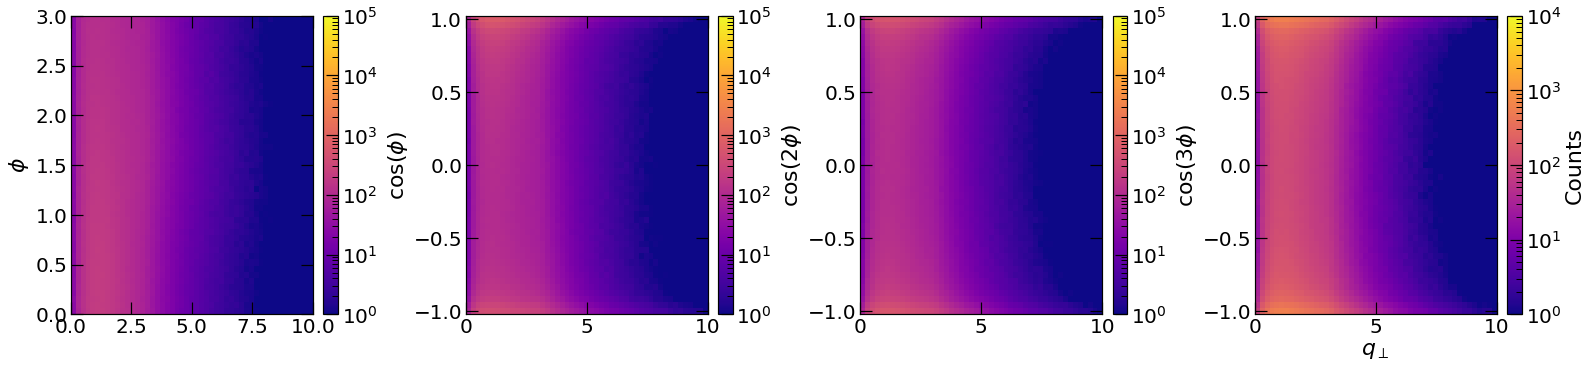

In [27]:
N_Bins = 50
xbins = np.linspace(-0.01,10.01,N_Bins)
ybins = np.linspace(-1.02,1.02,N_Bins)
cmap = copy(plt.cm.plasma)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 5), constrained_layout=True)


h0, xedges0, yedges0 = np.histogram2d(q_perp, (asymm_phi), bins=(np.linspace(0,10,N_Bins),np.linspace(0,3,N_Bins)), weights=weights)
h1, xedges1, yedges1 = np.histogram2d(q_perp, np.cos(asymm_phi),bins=(xbins,ybins), weights=weights)
h2, xedges2, yedges2 = np.histogram2d(q_perp, np.cos(2*asymm_phi), bins=(xbins,ybins), weights=weights)
h3, xedges3, yedges3 = np.histogram2d(q_perp, np.cos(3*asymm_phi), bins=(xbins,ybins), weights=weights)

pcm0 = axes[0].pcolormesh(xedges0, yedges0, h0.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm1 = axes[1].pcolormesh(xedges1, yedges1, h1.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm2 = axes[2].pcolormesh(xedges2, yedges2, h2.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e5), rasterized=True)
pcm3 = axes[3].pcolormesh(xedges3, yedges3, h3.T, cmap=cmap, norm=LogNorm(vmin=1.0e0,vmax=1.0e4), rasterized=True)
axes[0].set_ylabel("$\phi$",fontsize=22)
axes[1].set_ylabel("$\cos(\phi)$",fontsize=22)
axes[2].set_ylabel("$\cos(2\phi)$",fontsize=22)
axes[3].set_ylabel("$\cos(3\phi)$",fontsize=22)
#cb0=axes[0].colorbar(pcm,ax)

fig.colorbar(pcm0, ax=axes[0], pad= -0.049)
fig.colorbar(pcm1, ax=axes[1], pad= -0.01)
fig.colorbar(pcm2, ax=axes[2], pad= -0.01)
cb=fig.colorbar(pcm3, ax=axes[3], pad= -0.01)

plt.xlabel("$q_\perp$",fontsize=22)
cb.set_label("Counts",fontsize=22)
plt.savefig("2D_asymmetries.png")

<ErrorbarContainer object of 3 artists>

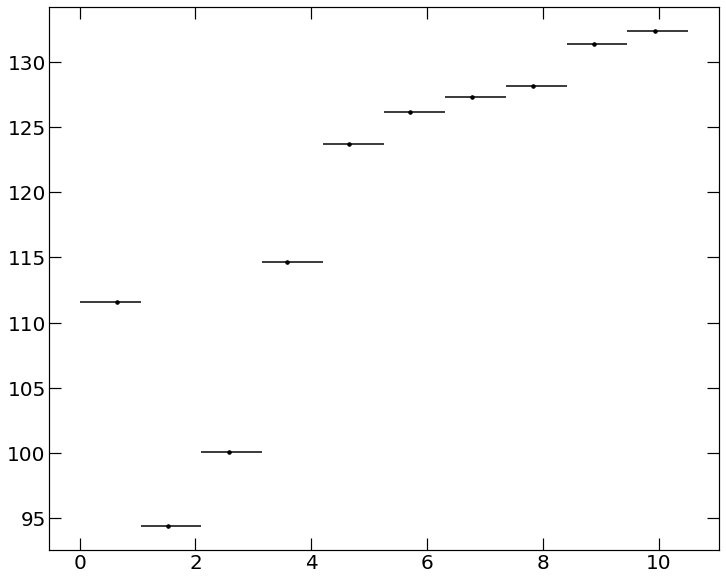

In [28]:
plt.errorbar(h1_rpgp["q_perp"],h1_rpgp["phi"],yerr=btstrp_errors*h1_rpgp[key],xerr=x_errors,
                         label="H1 OmniFold [Rapgap]",ls='none',ms=7,marker=".", color='black')